# How to use paramManager
paramManager writes and reads parameter files for data file sets, one structured parameter dictionary per data file.
The routines here are just for demonstrative purposes, feel free to use any library/tools to extract the parameter values that you want. Then use paramManager to create parameter files with those values.

In [1]:
import numpy as np
import librosa # conda install -c conda-forge librosa
import librosa.display

import os  # for mkdir
from os import listdir
from os.path import isfile, join
import sys

%matplotlib inline
import matplotlib.pyplot as plt

##-----------   paramManager  interface   ------------------##
from paramManager import paramManager

## paramManager on a directory (normal operation)

In [2]:
datapath='../data/audio'  #root folder
parampath='../data/param' 
# print the files (but not the directories) in datapath
fileList = [f for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]
#fileList,fnameList = listDirectory_all(datapath)
len(fileList)

38

In [3]:
# paramManager, create 
pm=paramManager(datapath, parampath)  ##-----------   paramManager  interface ------------------##

In [4]:
# initialize parameter files for the data (only necessary if they don't already exist)
# set overwrite=True for initial creation
# The boolean parameter tells whether to overwrite current parameter directory (default is False)
pm.initParamFiles(overwrite=False) ##-----------   paramManager  interface ------------------##

../data/param already exists and overite is False; Not initializing


In [5]:
# paramManager , check that data files and paramfiles match in number and name
pm.checkIntegrity() ##-----------   paramManager  interface   ------------------##

True

In [6]:
# param Manager , get the parameter dictionary for a file 
# This is the critical function for getting parameters for training nets. 

##-----------   paramManager  interface   ------------------##
foo=pm.getParams(datapath+'/1-4211-a') #extension is optional
foo

{'meta': {'filename': '1-4211-a.wav'},
 'rmse': {'times': [0.0,
   0.015015015015015015,
   0.03003003003003003,
   0.04504504504504504,
   0.06006006006006006,
   0.07507507507507508,
   0.09009009009009009,
   0.10510510510510511,
   0.12012012012012012,
   0.13513513513513514,
   0.15015015015015015,
   0.16516516516516516,
   0.18018018018018017,
   0.19519519519519518,
   0.21021021021021022,
   0.22522522522522523,
   0.24024024024024024,
   0.2552552552552553,
   0.2702702702702703,
   0.2852852852852853,
   0.3003003003003003,
   0.3153153153153153,
   0.3303303303303303,
   0.34534534534534533,
   0.36036036036036034,
   0.37537537537537535,
   0.39039039039039036,
   0.40540540540540543,
   0.42042042042042044,
   0.43543543543543545,
   0.45045045045045046,
   0.46546546546546547,
   0.4804804804804805,
   0.4954954954954955,
   0.5105105105105106,
   0.5255255255255256,
   0.5405405405405406,
   0.5555555555555556,
   0.5705705705705706,
   0.5855855855855856,
   0.60060060

## paramManager on a single file (special use case)

In [7]:
datapath='ZOOM0001.wav'  #datapath is pointing to an audio file
parampath='.'           #parampath is the parent folder containing/will contain the corresponding param file 
pm=paramManager(datapath, parampath)

In [8]:
pm.initParamFiles(overwrite=False) #set overwrite=True if creating paramfile for the first time 

. already exists and overite is False; Not initializing


In [9]:
pm.checkIntegrity() 

True

In [10]:
foo=pm.getParamNames(datapath) #extension is optional
foo

['meta']

# First a little essentia demo

In [ ]:
# http://essentia.upf.edu/documentation/documentation.html
import essentia # conda install -c thomasfillon essentia
import essentia.standard


In [ ]:
testfile = datapath + '/' + 'reed_acoustic_000-072-127.wav'

loader = essentia.standard.AudioLoader(filename=testfile) #Monoloader doesn't get metadata

# and then we actually perform the loading:
(audio, sr,chans,_,_,_) = loader()
print("shape of audio is  is {}".format(audio.shape))
print("chans is {}".format(chans))
print("audio is {}".format(audio))
audio=audio[:,0] #get (the) one (and only) channel

import IPython
IPython.display.Audio(testfile)


In [ ]:
PitchMelodia = essentia.standard.PitchMelodia( binResolution=2, sampleRate=sr, guessUnvoiced=True) # donothing??: , minFrequency=10, maxFrequency=200)
p, pc = PitchMelodia(audio )
pitch_times = np.linspace(0.0,len(audio)/sr,len(p) )
plt.figure()
plt.title("Pitch:")
plt.plot(pitch_times,p)

# paramManager - analyze data files to create a new parameter with Essentia

In [ ]:
# Get a list of data file names so we can pass them to essentia for analysis
for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    loader = essentia.standard.AudioLoader(filename=fname) #Monoloader doesn't get metadata
    (audio, sr,chans,_,_,_) = loader()
    audio=audio[:,0] #get (the) one (and only) channel
    
    PitchMelodia = essentia.standard.PitchMelodia( binResolution=2, sampleRate=sr, guessUnvoiced=True) # donothing??: , minFrequency=10, maxFrequency=200)
    p, pc = PitchMelodia(audio )
    
    # Need time points for the parameter file, which essentia does not provide
    pitch_times = np.linspace(0.0,len(audio)/sr,len(p) )
    if (not (len(p) == len(pitch_times))) :
        print("Warning, num parameters not equal to time points")
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "pitch", pitch_times, p, units="frequency", nvals=0, minval=0, maxval=1)
    
    

In [ ]:
len(audio)/sr

In [ ]:
# Here we show how to get a particular parameater from the pdict for a datafile
##-----------   paramManager  interface   ------------------##
fooparams=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foopitch=fooparams['pitch']

#now just show that it looks the same as the essential data 
title=fooparams['meta']['filename']
plt.figure()
plt.title(title)
plt.plot(foopitch['times'], foopitch['values'])

# Librosa demo

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

sig,sr=librosa.core.load(datapath + "/" + "reed_acoustic_000-072-127.wav", sr=None)
rmse=librosa.feature.rmse(y=sig)[0]
rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse) )

plt.figure()
plt.subplot(2, 1, 1)
#plt.semilogy(rmse.T, label='RMS Energy')
plt.plot(rmse_times, rmse, label='RMS Energy')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
librosa.display.waveplot(sig, sr=16000)

print('duration=',len(sig)/sr)

In [ ]:
datafiles = [fname for fname in pm.getFullPathNames(datapath)]
#check all durations are the same
def check_duration(filelist):
    """use librosa's get_duration method to find the duration of all files in filelist"""
    filedurations = [librosa.core.get_duration(filename=f) for f in filelist]
    assert filedurations.count(filedurations[0]) == len(filedurations), "File durations are not all the same!"
    return filedurations[0]

duration = check_duration(datafiles) 
print(duration)

# paramManager - analyze data files to create a new parameter with LibRosa 

In [5]:
# parameters: rmse - frame_length=4000, hop_length=1000
#             spectral centroid - n_fft=4000, hop_length=1000 


for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))

    sig,sr=librosa.core.load(fname, sr=None)
    rmse=librosa.feature.rmse(y=sig, frame_length=4000, hop_length=1000)[0]
    sc = librosa.feature.spectral_centroid(y=sig, sr=16000, n_fft=4000, hop_length=1000)[0]
    
    sig_times = np.linspace(0.0,len(sig)/sr, len(sig))
    rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse))
    sc_times = np.linspace(0.0,len(sig)/sr, len(sc))
    
    """
    fig, ax1 = plt.subplots(figsize=(16,3))

    lns1=ax1.plot(sig_times,sig,label='sig',color='k')
    lns2=ax1.plot(rmse_times,rmse,label='rmse')
    
    ax2 = ax1.twinx()
    lns3=ax2.plot(sc_times,sc,label='sc',color='r')
    
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    ax1.set_ylim(-1, 1)
    ax2.set_ylim(0,8000)
    plt.grid()
    plt.show()
    """
    break
print(len(sig))
print(len(rmse))
print(len(sc))
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    #pm.addParam(fname, "rmse", rmse_times, rmse, units="energy", nvals=0, minval=0, maxval=None)
    #pm.addParam(fname, "spec_centroid", sc_times, sc, units="frequency", nvals=0, minval=0, maxval=None)
    

processing ../data/audio\1-17150-a.wav
80000
81
81


processing ../data/audio\1-17150-a.wav


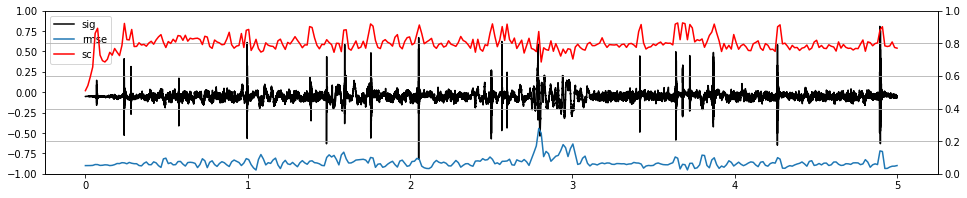

processing ../data/audio\1-17565-a.wav


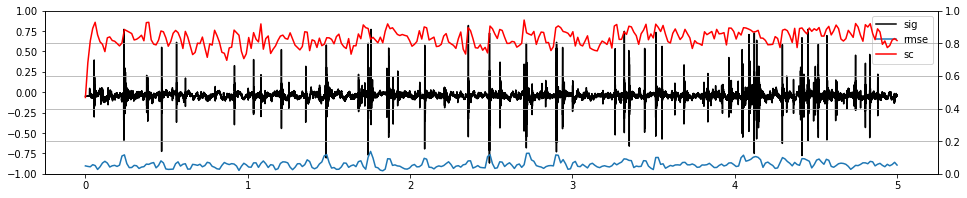

processing ../data/audio\1-17742-a.wav


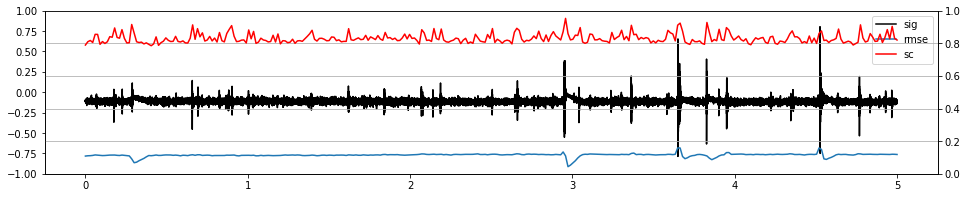

processing ../data/audio\1-17808-a.wav


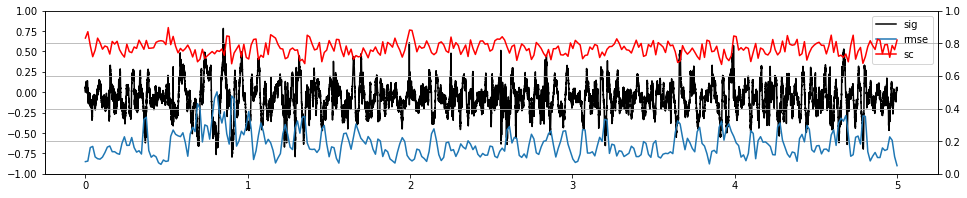

processing ../data/audio\1-17808-b.wav


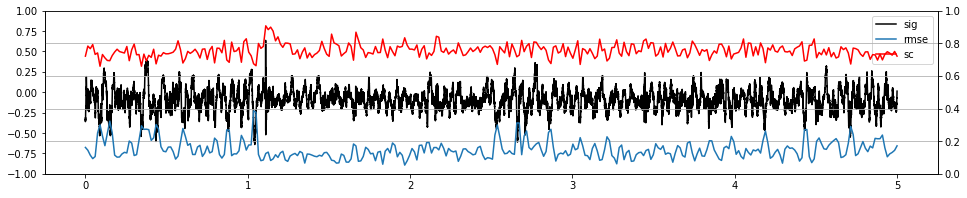

processing ../data/audio\1-4211-a.wav


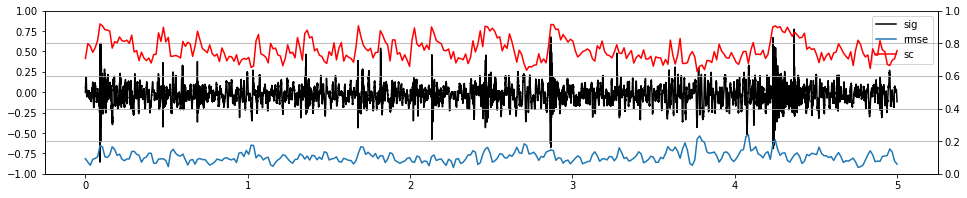

processing ../data/audio\1-46272-a.wav


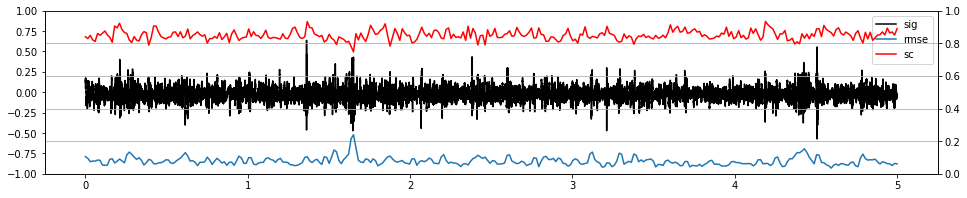

processing ../data/audio\1-7057-a.wav


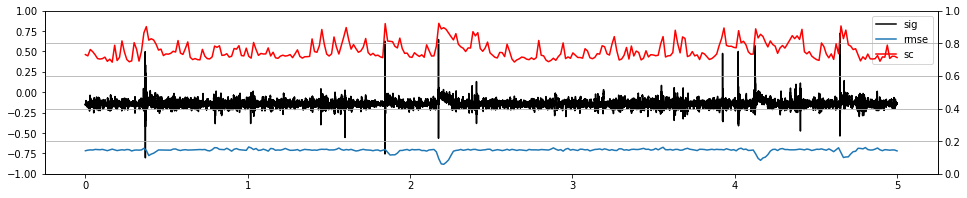

processing ../data/audio\2-18766-a.wav


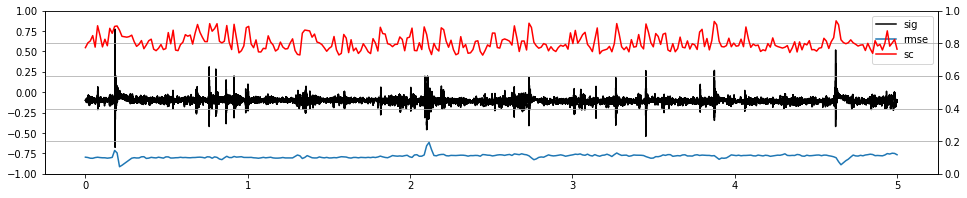

processing ../data/audio\2-18766-b.wav


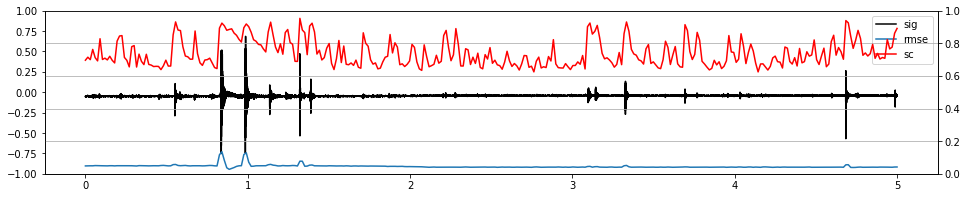

processing ../data/audio\2-28314-a.wav


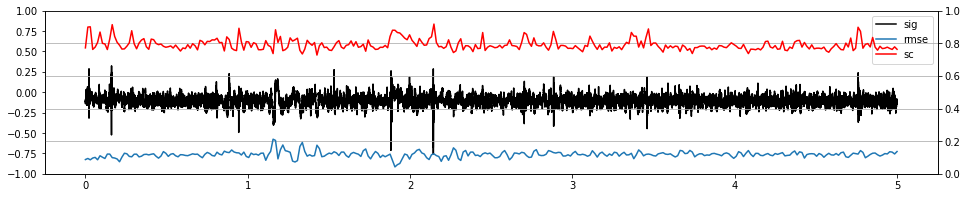

processing ../data/audio\2-28314-b.wav


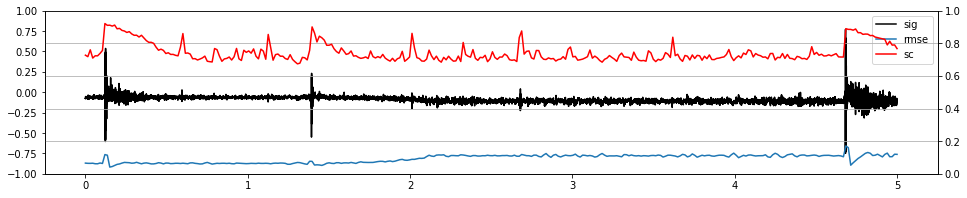

processing ../data/audio\2-30322-a.wav


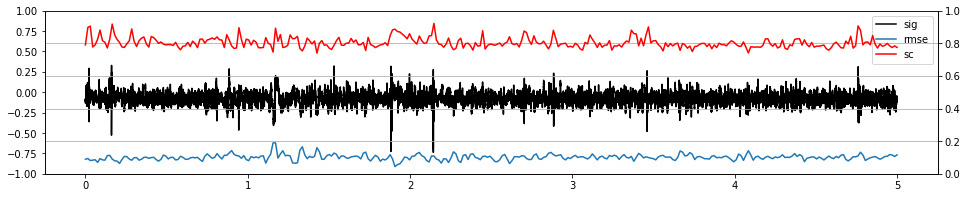

processing ../data/audio\2-30322-b.wav


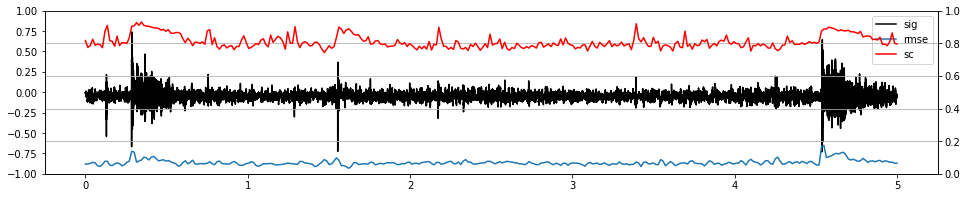

processing ../data/audio\2-61311-a.wav


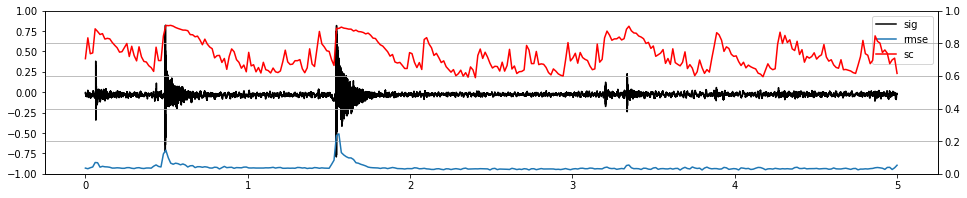

processing ../data/audio\2-65747-a.wav


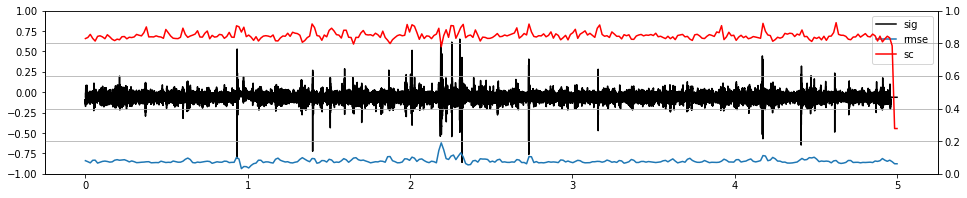

processing ../data/audio\3-104958-a.wav


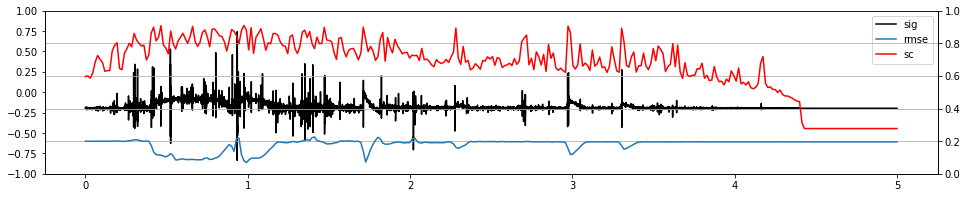

processing ../data/audio\3-120644-a.wav


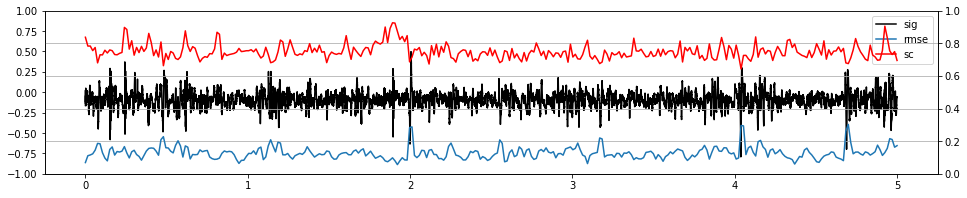

processing ../data/audio\3-145774-a.wav


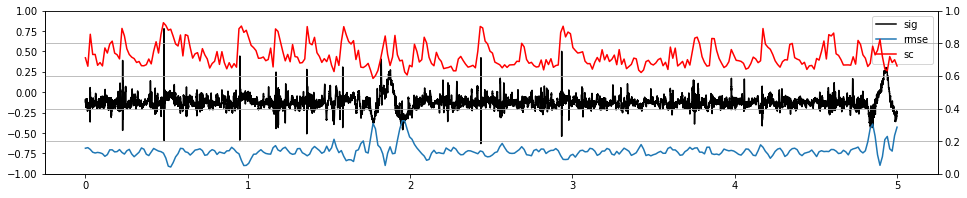

processing ../data/audio\3-147965-a.wav


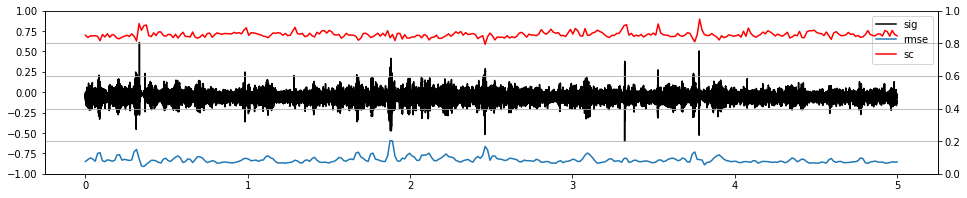

processing ../data/audio\3-158476-a.wav


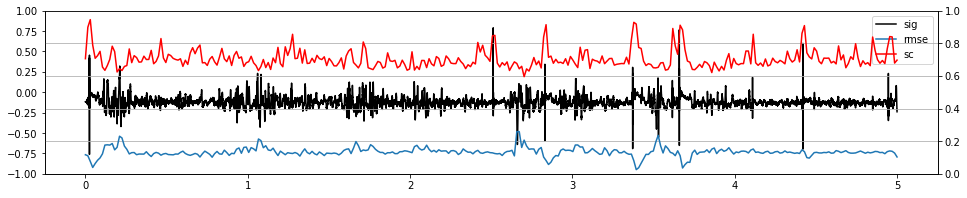

processing ../data/audio\3-65748-a.wav


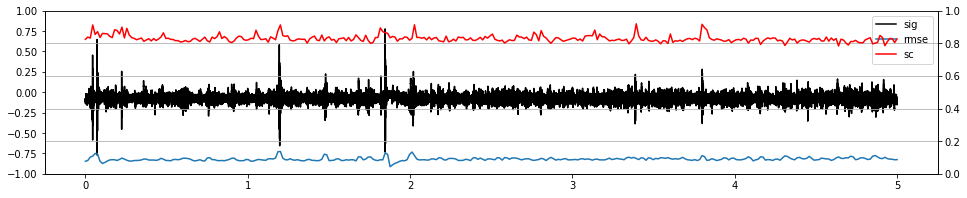

processing ../data/audio\4-164661-a.wav


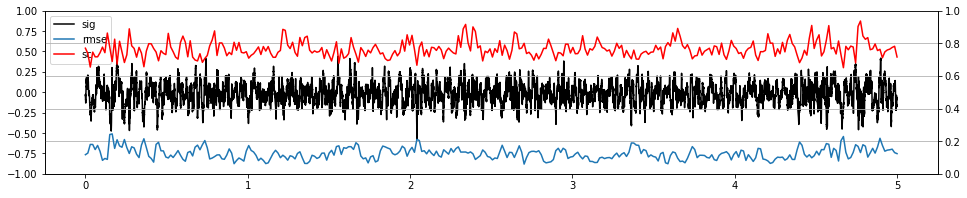

processing ../data/audio\4-164661-b.wav


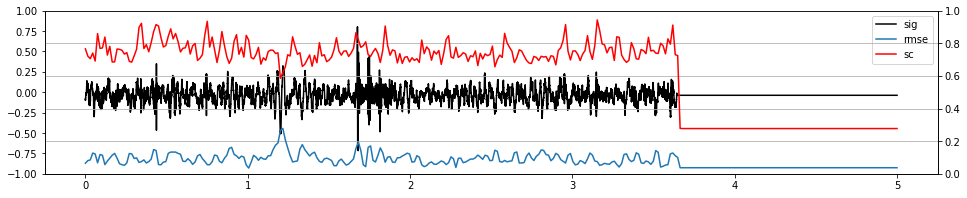

processing ../data/audio\4-170247-a.wav


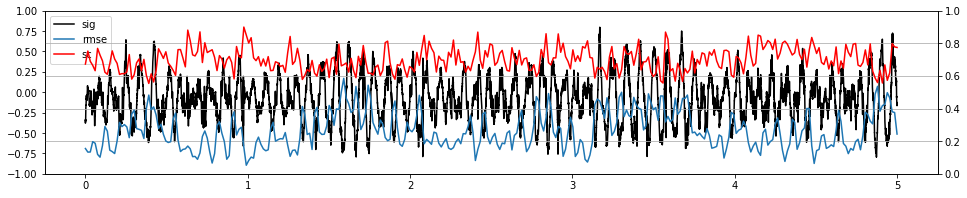

processing ../data/audio\4-170247-b.wav


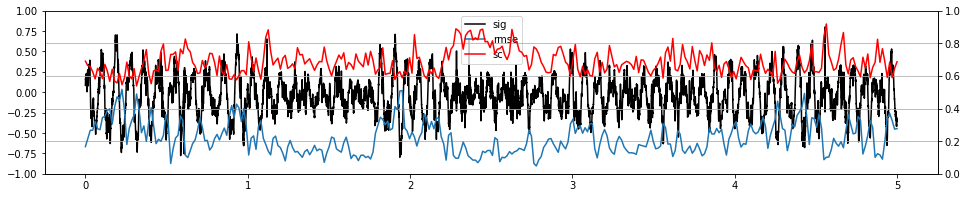

processing ../data/audio\4-171207-a.wav


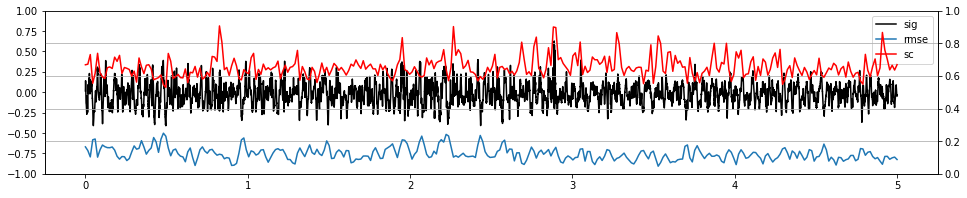

processing ../data/audio\4-181563-a.wav


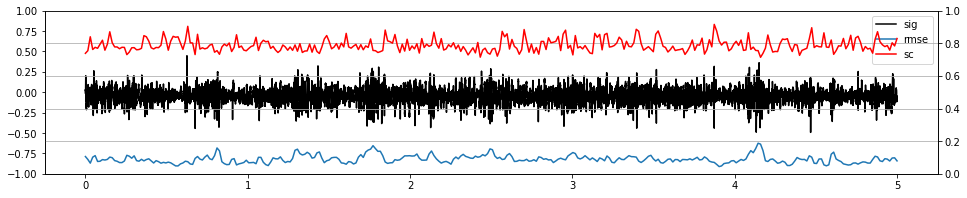

processing ../data/audio\4-182368-a.wav


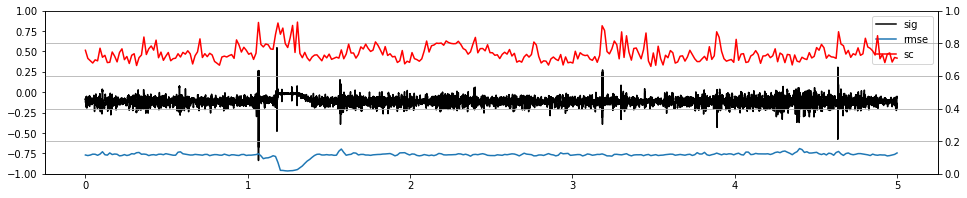

processing ../data/audio\4-182369-a.wav


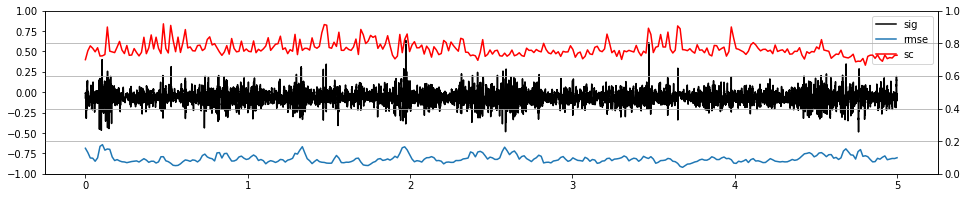

processing ../data/audio\5-186924-a.wav


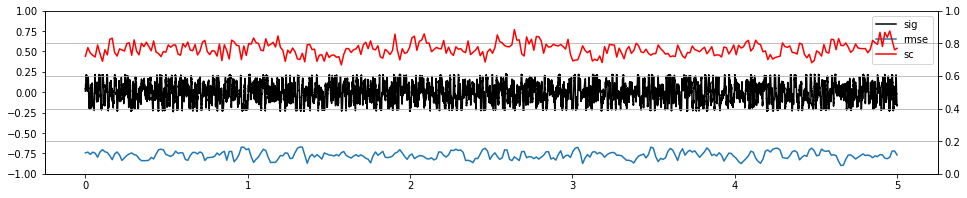

processing ../data/audio\5-189212-a.wav


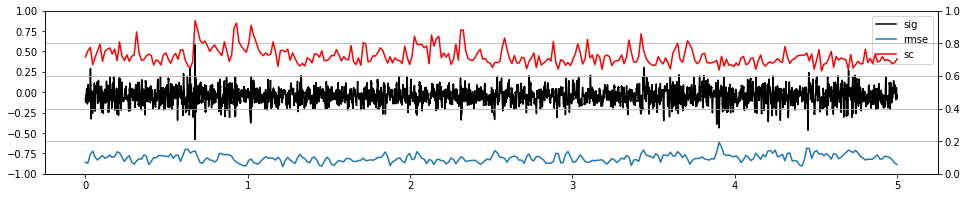

processing ../data/audio\5-189237-a.wav


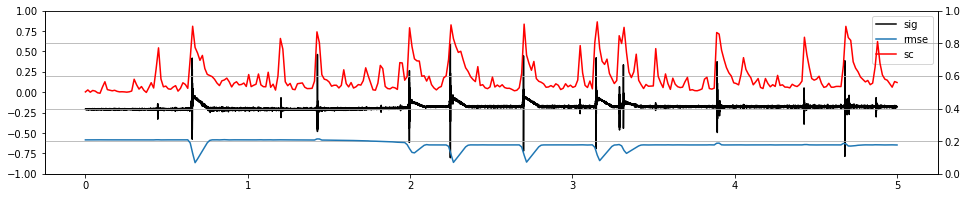

processing ../data/audio\5-193473-a.wav


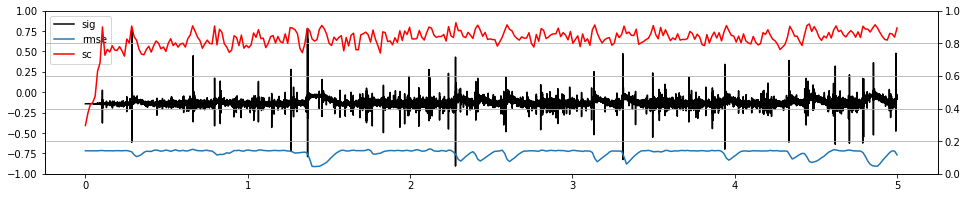

processing ../data/audio\5-193473-b.wav


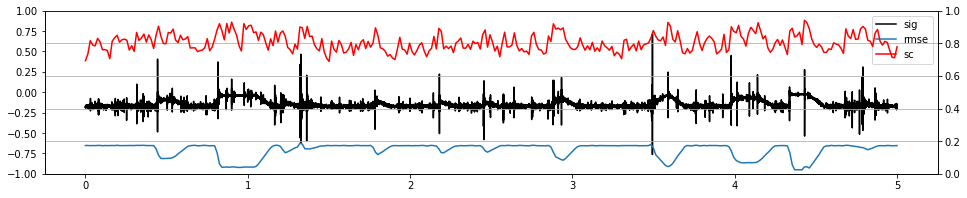

processing ../data/audio\5-213802-a.wav


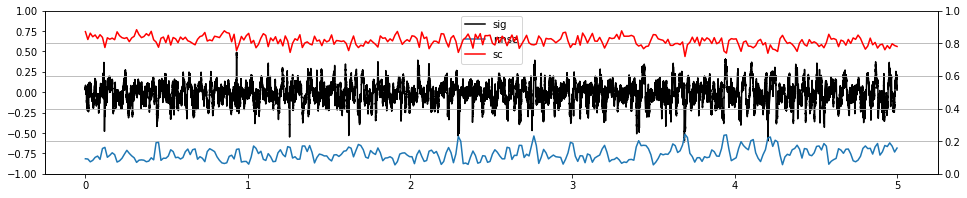

processing ../data/audio\5-215658-a.wav


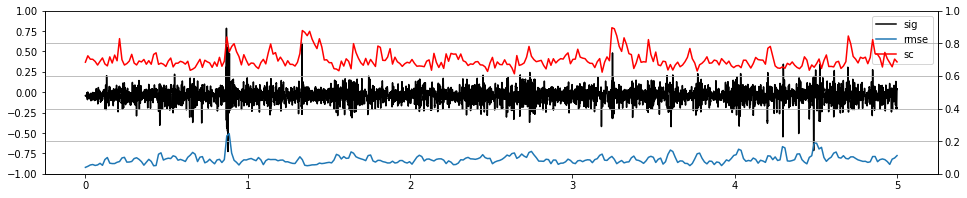

processing ../data/audio\5-215658-b.wav


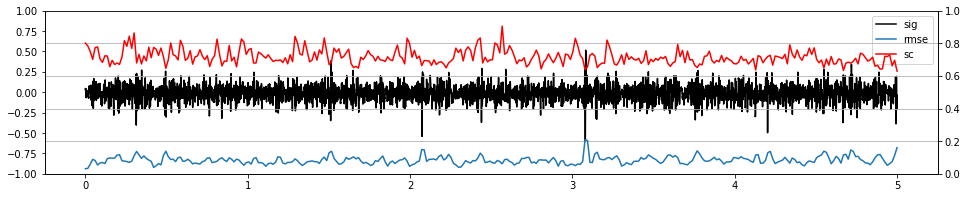

(80000,)
(334,)
[799.21826656 196.46300625 120.00020033 128.13941806  69.02873351
  74.36550116  50.64874012  54.01408349  46.2949566   59.25948916
  39.98589715  39.0585561   41.29804449]
[8.53977000e+01 9.39303735e-03 2.07881525e-03 2.69970115e-02
 1.50980369e-04 2.28647387e-04 1.26094820e-03 5.15156549e-04
 5.01339028e-05 4.47907972e-03 8.59607458e-04 2.46402716e-03
 1.18269447e-04]


In [54]:
#parameters frame 30ms with 50% hop sr~67
# parameters: rmse - frame_length=480, hop_length=240
#             spectral centroid - n_fft=480, hop_length=240
#             mfcc - n_mfcc=13, dct_type=2, lifter=0, n_fft=480, hop_length=240 
mfcc_maxs = np.zeros((38,13))
mfcc_mins = np.zeros((38,13))
i = 0

for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))

    sig,sr=librosa.core.load(fname, sr=None)
    rmse=librosa.feature.rmse(y=sig, frame_length=480, hop_length=240)[0]
    sc = librosa.feature.spectral_centroid(y=sig, sr=16000, n_fft=480, hop_length=240)[0]
    mfcc = librosa.feature.mfcc(y=sig, sr=16000, n_mfcc=13, n_fft=480, hop_length=240)
    
    sig_times = np.linspace(0.0,len(sig)/sr, len(sig))
    rmse_times = np.linspace(0.0,len(sig)/sr, len(rmse))
    sc_times = np.linspace(0.0,len(sig)/sr, len(sc))
    
    #sc_log = np.log(sc)
    sc_logone = np.log1p(sc)
    sc_norm = sc_logone / np.log1p(8000)
    #plt.figure(figsize=(10, 4))
    #plt.plot(sc,label='sc')
    #plt.plot(sc_logone,label='log(1+sc)')
    #plt.plot(sc_log,label='log(sc)')
    #plt.plot(sc_norm,label='sc norm')
    #plt.ylim((0, 1))
    #plt.legend()
    #plt.grid()
    #plt.show()
    
    
    fig, ax1 = plt.subplots(figsize=(16,3))

    lns1=ax1.plot(sig_times,sig,label='sig',color='k')
   
    ax2 = ax1.twinx()
    lns2=ax2.plot(rmse_times,rmse,label='rmse')
    lns3=ax2.plot(sc_times,sc_norm,label='sc',color='r')
    
    lns = lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    ax1.set_ylim(-1, 1)
    ax2.set_ylim(0,1)
    plt.grid()
    plt.show()
    
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=16000, hop_length=240)
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()
    """
    mfcc_max = np.amax(np.absolute(mfcc),axis=1)
    mfcc_min = np.amin(np.absolute(mfcc),axis=1)
    mfcc_maxs[i] = mfcc_max
    mfcc_mins[i] = mfcc_min
    #print(max(x.min(), x.max(), key=abs))
    
    
    i += 1
    
    
    # Now add the data to the parameter file
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "rmse", rmse_times, rmse, units="energy", nvals=0, minval=0, maxval=None)
    pm.addParam(fname, "spec_centroid", sc_times, sc_norm, units="frequency", nvals=0, minval=0, maxval=None)

print(sig.shape)
print(rmse.shape)
#print(sc.max(),sc.min())
#print(sc)
#print(sc_log)

max_mfcc = np.amax(mfcc_maxs,axis=0)
min_mfcc= np.amin(mfcc_mins,axis=0)
print(max_mfcc)
print(min_mfcc)

[0.         0.01501502 0.03003003 0.04504505 0.06006006 0.07507508
 0.09009009 0.10510511 0.12012012 0.13513514 0.15015015 0.16516517
 0.18018018 0.1951952  0.21021021 0.22522523 0.24024024 0.25525526
 0.27027027 0.28528529 0.3003003  0.31531532 0.33033033 0.34534535
 0.36036036 0.37537538 0.39039039 0.40540541 0.42042042 0.43543544
 0.45045045 0.46546547 0.48048048 0.4954955  0.51051051 0.52552553
 0.54054054 0.55555556 0.57057057 0.58558559 0.6006006  0.61561562
 0.63063063 0.64564565 0.66066066 0.67567568 0.69069069 0.70570571
 0.72072072 0.73573574 0.75075075 0.76576577 0.78078078 0.7957958
 0.81081081 0.82582583 0.84084084 0.85585586 0.87087087 0.88588589
 0.9009009  0.91591592 0.93093093 0.94594595 0.96096096 0.97597598
 0.99099099 1.00600601 1.02102102 1.03603604 1.05105105 1.06606607
 1.08108108 1.0960961  1.11111111 1.12612613 1.14114114 1.15615616
 1.17117117 1.18618619 1.2012012  1.21621622 1.23123123 1.24624625
 1.26126126 1.27627628 1.29129129 1.30630631 1.32132132 1.33633

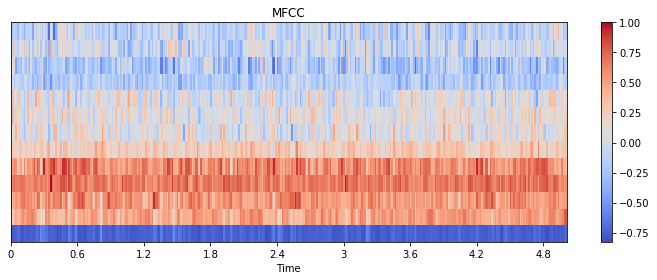

processing ../data/audio\1-17565-a.wav


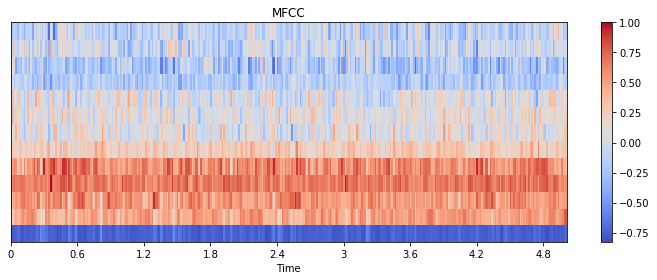

processing ../data/audio\1-17742-a.wav


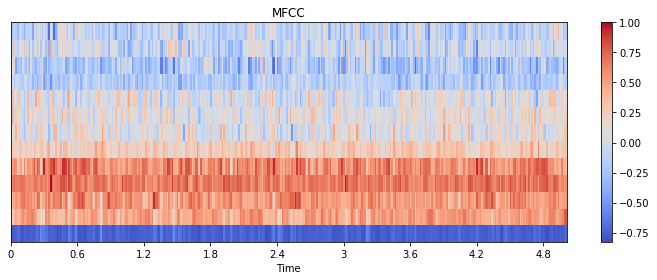

processing ../data/audio\1-17808-a.wav


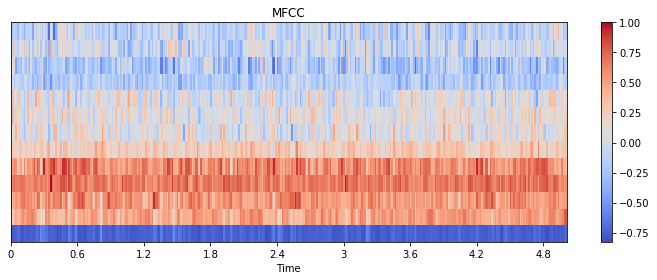

processing ../data/audio\1-17808-b.wav


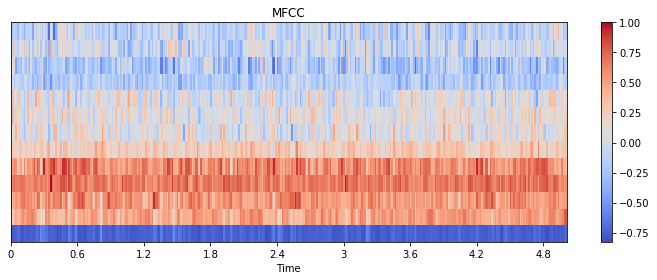

processing ../data/audio\1-4211-a.wav


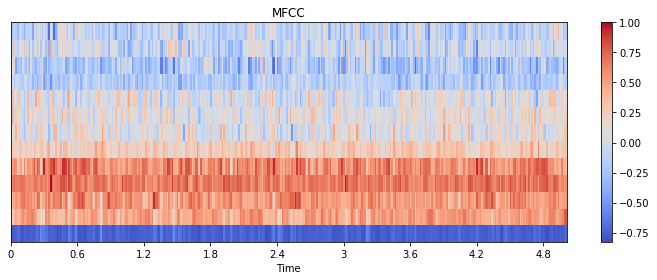

processing ../data/audio\1-46272-a.wav


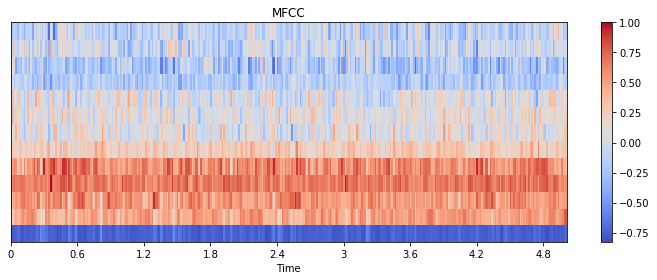

processing ../data/audio\1-7057-a.wav


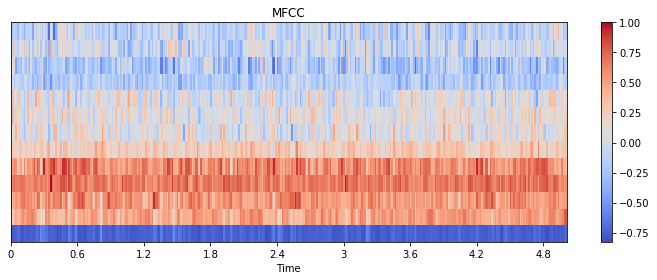

processing ../data/audio\2-18766-a.wav


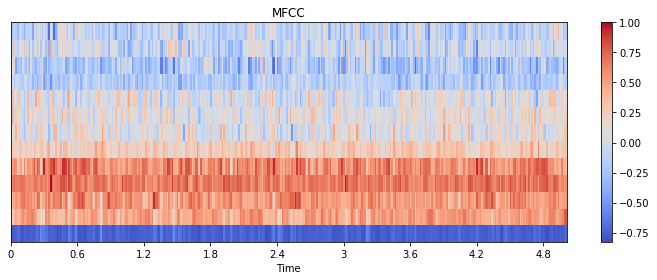

processing ../data/audio\2-18766-b.wav


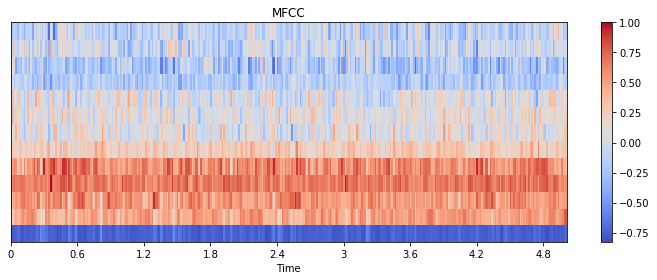

processing ../data/audio\2-28314-a.wav


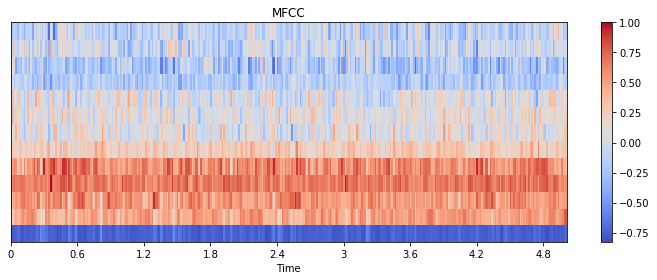

processing ../data/audio\2-28314-b.wav


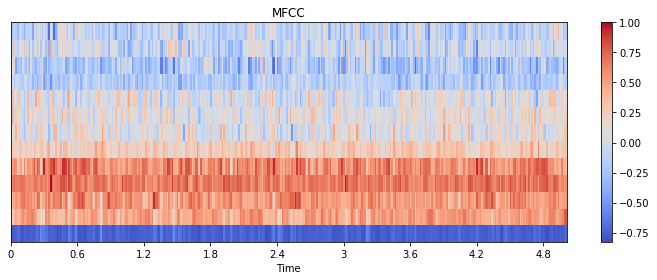

processing ../data/audio\2-30322-a.wav


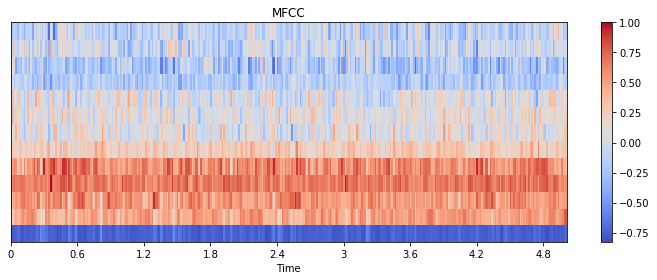

processing ../data/audio\2-30322-b.wav


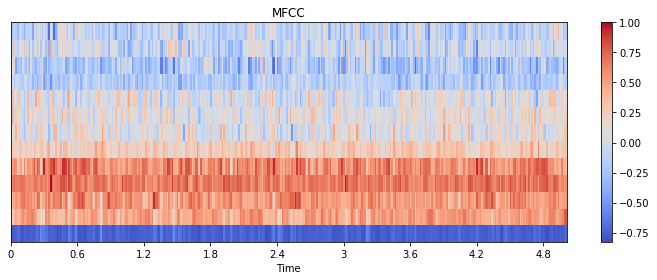

processing ../data/audio\2-61311-a.wav


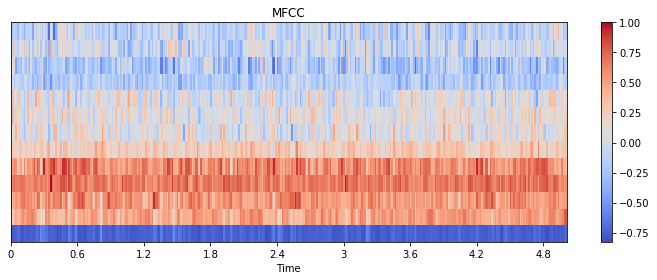

processing ../data/audio\2-65747-a.wav


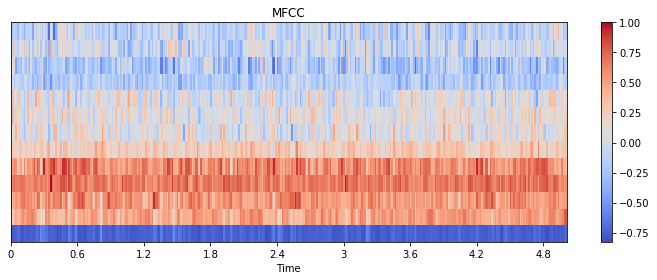

processing ../data/audio\3-104958-a.wav


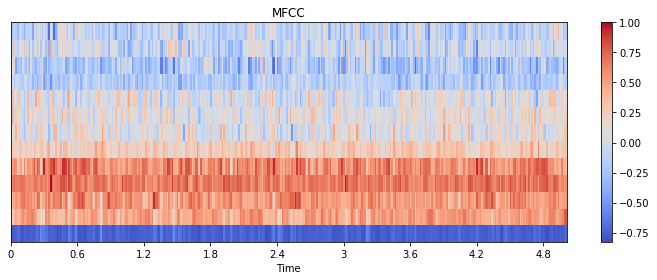

processing ../data/audio\3-120644-a.wav


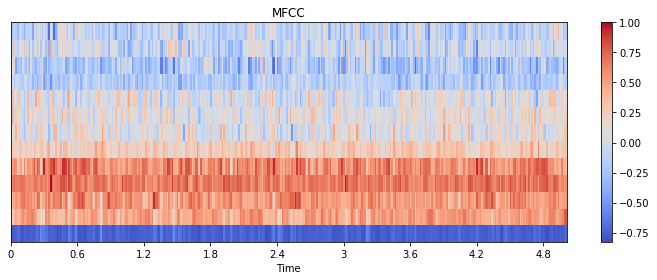

processing ../data/audio\3-145774-a.wav


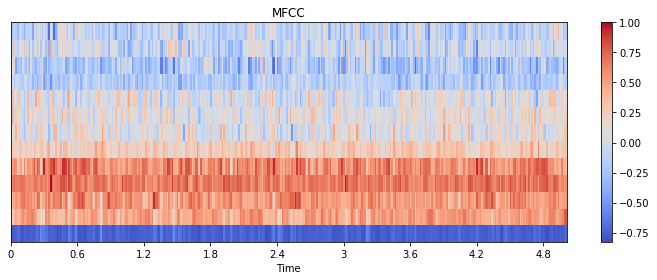

processing ../data/audio\3-147965-a.wav


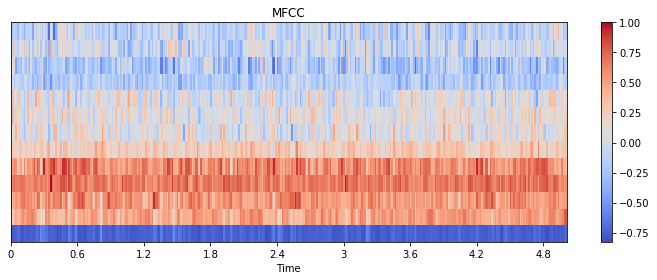

processing ../data/audio\3-158476-a.wav


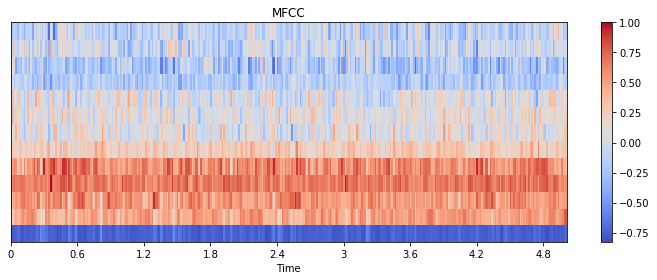

processing ../data/audio\3-65748-a.wav


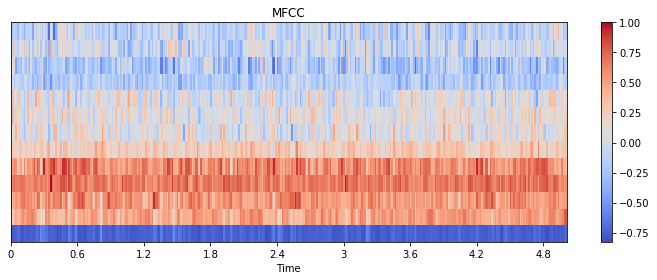

processing ../data/audio\4-164661-a.wav


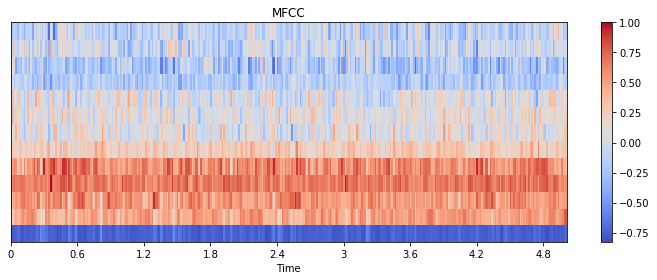

processing ../data/audio\4-164661-b.wav


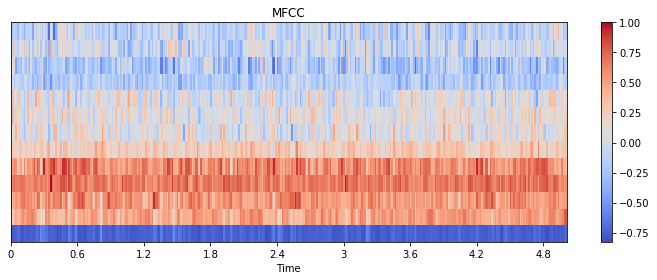

processing ../data/audio\4-170247-a.wav


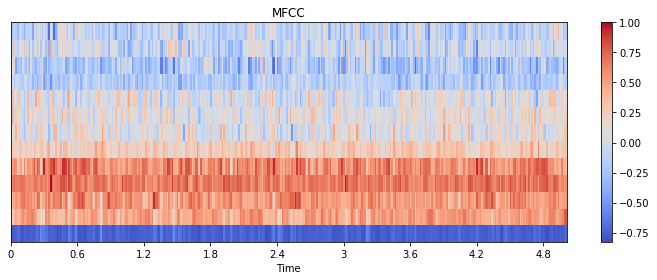

processing ../data/audio\4-170247-b.wav


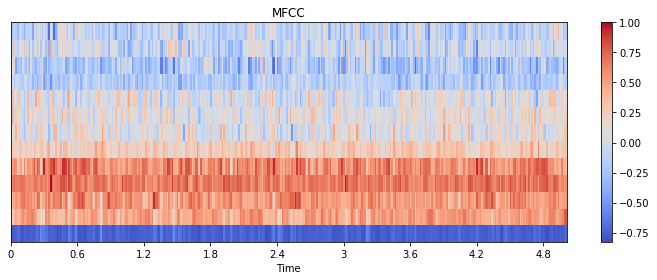

processing ../data/audio\4-171207-a.wav


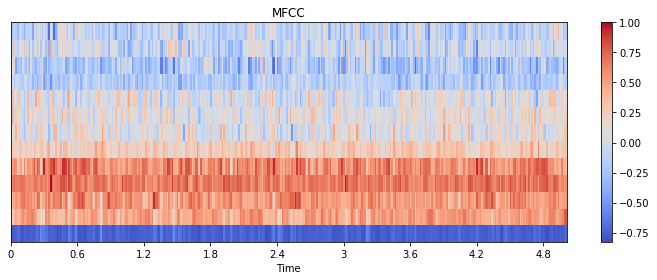

processing ../data/audio\4-181563-a.wav


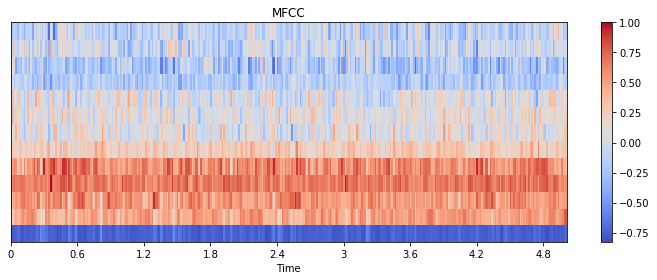

processing ../data/audio\4-182368-a.wav


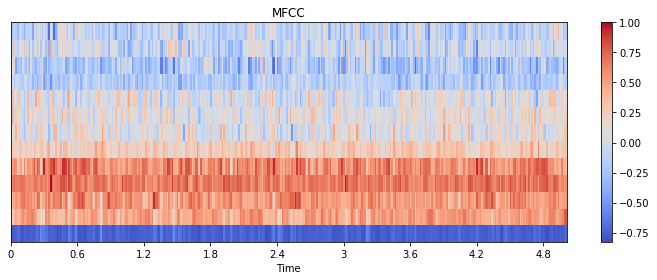

processing ../data/audio\4-182369-a.wav


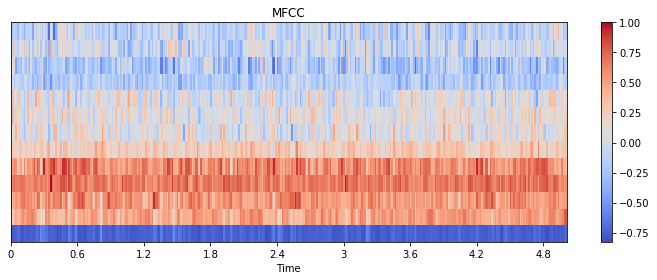

processing ../data/audio\5-186924-a.wav


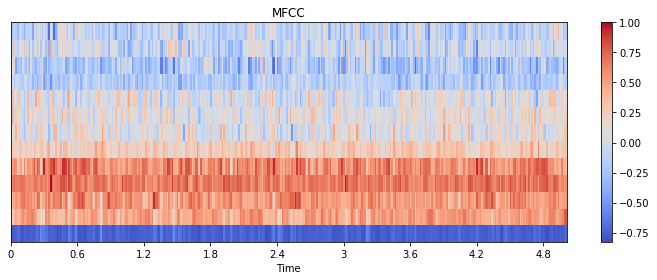

processing ../data/audio\5-189212-a.wav


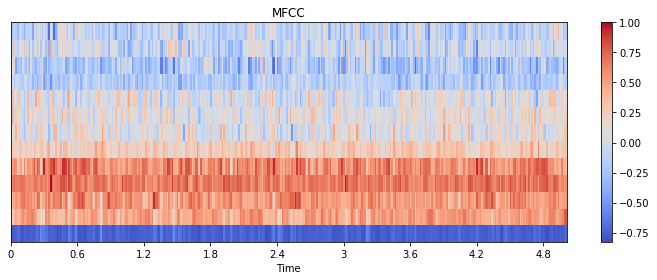

processing ../data/audio\5-189237-a.wav


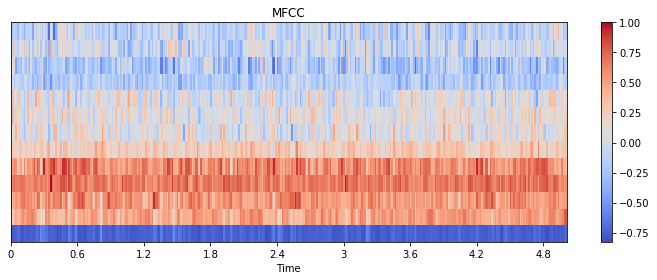

processing ../data/audio\5-193473-a.wav


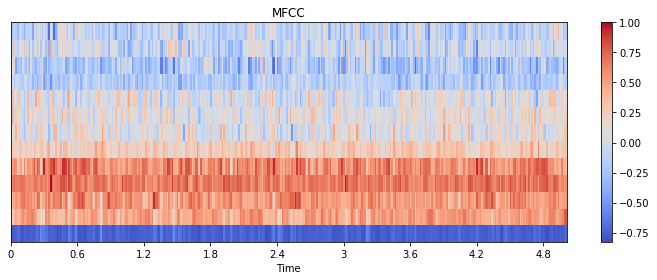

processing ../data/audio\5-193473-b.wav


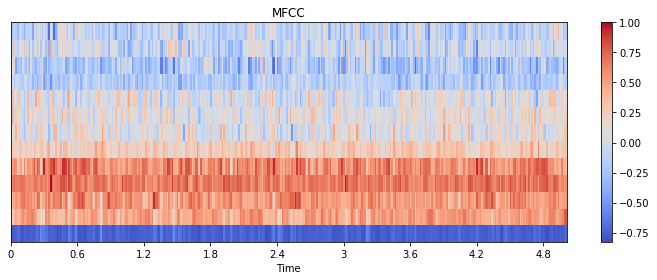

processing ../data/audio\5-213802-a.wav


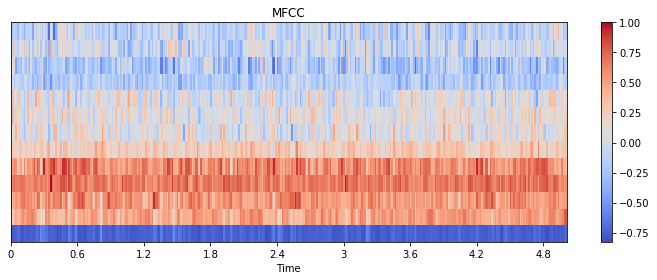

processing ../data/audio\5-215658-a.wav


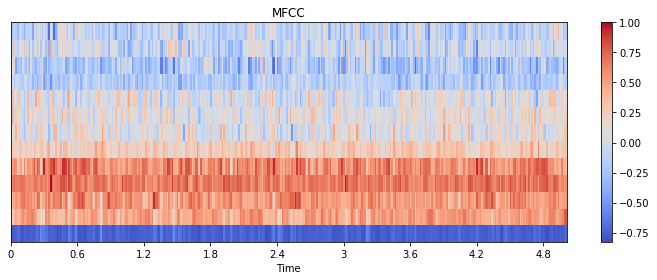

processing ../data/audio\5-215658-b.wav


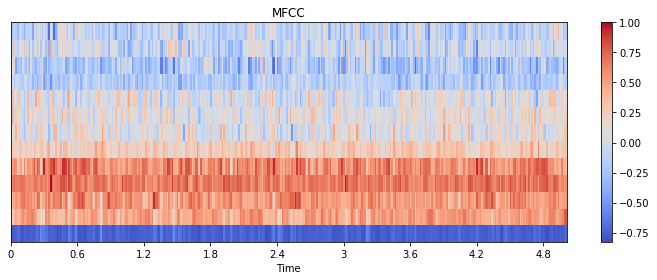

In [66]:
mfcc_times = np.linspace(0.0,len(sig)/sr, mfcc.shape[1])
print(mfcc_times.shape)

for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    
    mfcc = librosa.feature.mfcc(y=sig, sr=16000, n_mfcc=13, n_fft=480, hop_length=240)
    #print(mfcc)
    for i in range(mfcc.shape[0]):
        mfcc[i,:] = (mfcc[i,:] - min_mfcc[i]) / (max_mfcc[i] - min_mfcc[i])
        
        pm.addParam(fname, "mfcc"+str(i), mfcc_times, mfcc[i,:], units="None", nvals=0, minval=0, maxval=None)

    #print(mfcc)
    

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=16000, hop_length=240)
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

    

# paramManager, add params from info stored in filenames

In [ ]:
import re

for fname in pm.getFullPathNames(datapath) :
    print("processing {}".format(fname))
    
    # first, instrument ID
    if fname.find("brass") >=0 : 
        instID=0
    else : 
        instID=1
    print("    {} is in category {}".format(fname, 1))
            
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "instID", [0.0,duration], [instID,instID], units="category", nvals=2, minval=0, maxval=1)
    

    #now midiPitch
    n=re.findall(r'(?<=-).*?(?=-)', fname)[0] #3-digit pitch number wedged between dashes (-) in name
    if (n[0]=='0') :
        midinum=int(n[1:])
    else :
        midinum=int(n)
    print("    midi number is {}".format(midinum))
    
    ##-----------   paramManager  interface   ------------------##
    pm.addParam(fname, "midiPitch", [0.0,duration], [midinum,midinum], units="midiPitch", nvals=128, minval=0, maxval=127)
    

In [ ]:
# Now lets have a look at one of our paramfiles
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav') #the path and extension are optional

# paramManager, add params from info stored in pandas dataframe

In [ ]:
import pandas as pd

dvectors = pd.read_pickle('/enrollments/full_3layer.pkl')
dvectors.head()

In [ ]:
from utils.myUtils import extract_nsynth_instrument,extract_nsynth_pitch
from os.path import basename

columns = [str(i) for i in range(16)]

for fname in pm.getFullPathNames(datapath) :
    #print(fname)
    base = basename(fname)
    print("processing {}".format(base))
    inst = extract_nsynth_instrument(base)
    pitch = extract_nsynth_pitch(base)
    a = dvectors.loc[lambda dvectors: (dvectors['inst'] == inst) & (dvectors['pitch'] == pitch)] 
    a_flat = np.squeeze(a[columns].values)
    #print(len(a_flat))
    
    for i in range(len(a_flat)):
        pm.addParam(fname, "dvector_"+str(i), [0.0,duration], [a_flat[i],a_flat[i]], units="category", nvals=0, minval='null', maxval='null')

# Resampling (interpolation) demo

In [ ]:
#sometimes we need parameter values at a different sampling rate
#for example we have a section of data made up of 6 samples, taken from 0.0s to 0.03s of reed_acoustic_000-072-127.wav
#but there are only 2 rmse (parameter) values associated with this duration
#to get a rmse (parameter) for each of our 6 samples, load the parameter file using getParams then pass it to resampleParam as follows:

pm.resampleParam(foo,"rmse",6,0.0,0.03,verbose=True)

#this function uses scipy's linear interpolation method

In [ ]:
#the default behaviour of resampleParam is not to overwrite the original param file

foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foo

In [ ]:
#but this can be changed if overwrite=True

pm.resampleParam(foo, "rmse",10,0.15,0.25,verbose=True,overwrite=True)
foo=pm.getParams(datapath + '/' + 'reed_acoustic_000-072-127.wav')
foo

In [ ]:
#instead of resampling 1 parameter at a time, use resampleAllParams to automatically interpolate all of them (will ignore meta)

paramdict = pm.resampleAllParams(foo,5,1.1,1.2,verbose=True)

In [ ]:
#we can even select which parameters to resample using the prop variable 
paramdict = pm.resampleAllParams(foo,5,1.1,1.2,prop=['instID','midiPitch'],verbose=True)

In [ ]:
foo=pm.getParams(datapath + '/' + 'flute_acoustic_000-055-050.params')
foo

In [ ]:
pm.resampleParam(foo,"dvector_0",4,0.0,0.5,verbose=True)